# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries

import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16

# Scikit-learn Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Jupyter Notebook Settings
%matplotlib inline

Load the dataset.

In [3]:
# Load and unzip the dataset

zip_path = 'data.zip'               # Path to the zipped dataset
extract_path = 'dataset/'           # Directory where data will be extracted

# Extract only if not already extracted
if not os.path.exists(extract_path) or len(os.listdir(extract_path)) == 0:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset successfully extracted to: {extract_path}")
else:
    print(f"Dataset already exists at: {extract_path}")

# List available categories (class folders)
categories = os.listdir(extract_path + "/data")
print("Available waste categories:", categories)

Dataset already exists at: dataset/
Available waste categories: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images

def show_image(image_path, figsize=(6, 6)):
    """Displays an image from the given path."""
    image = plt.imread(image_path)
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
# Function to load all raw images from a specific category folder

def load_images_from_category(folder_path):
    """
    Loads all valid image files from a given category folder.

    Args:
        folder_path (str): Path to a specific category folder (e.g., 'dataset/data/Glass').

    Returns:
        List of images as NumPy arrays.
    """
    images = []
    supported_exts = ('.jpg', '.jpeg', '.png')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(supported_exts):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    
    return images

In [6]:
# Example: Load raw images from one category ("Other")

dataset_path = "dataset/data"
category_folder =  "Other"

raw_images = load_images_from_category(dataset_path + "/" + category_folder)
print(f"Total images loaded from '{category_folder}': {len(raw_images)}")

Total images loaded from 'Other': 1010


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

Detected Waste Categories: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']

Showing one example per class:
Category: Cardboard


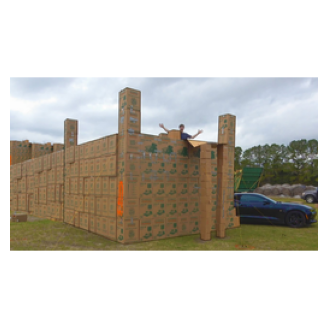

Category: Food_Waste


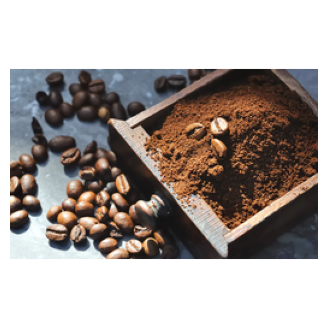

Category: Glass


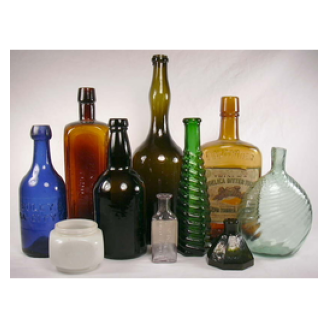

Category: Metal


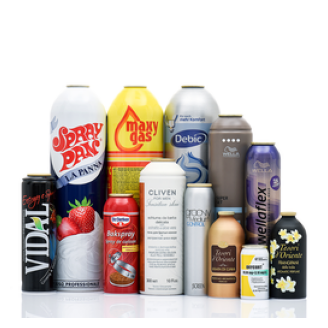

Category: Other


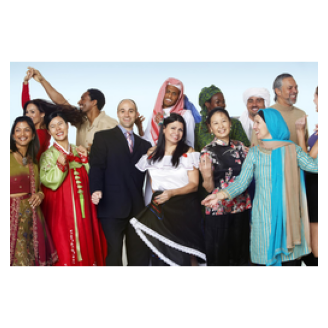

Category: Paper


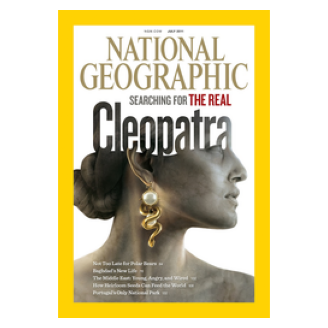

Category: Plastic


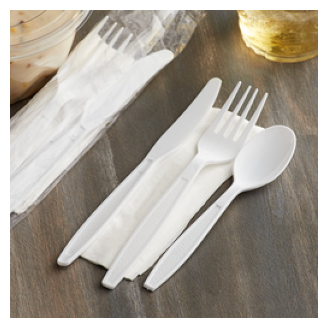

Loaded 540 images from Cardboard
Loaded 1000 images from Food_Waste
Loaded 750 images from Glass
Loaded 1000 images from Metal
Loaded 1010 images from Other
Loaded 1030 images from Paper
Loaded 2295 images from Plastic

✅ Total images loaded: 7625
🧷 Unique labels: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


In [7]:
# Get the images and their labels

data_root = 'dataset/data/'  # Adjusted based on previous unzip location
class_names = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])
print("Detected Waste Categories:", class_names)

# Optional: Display one sample image from each class
print("\nShowing one example per class:")
for category in class_names:
    category_path = os.path.join(data_root, category)
    for file in os.listdir(category_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            sample_path = os.path.join(category_path, file)
            print(f"Category: {category}")
            show_image(sample_path, figsize=(4, 4))
            break

# Function to load all images and their corresponding labels
def load_images_and_labels(dataset_path, target_size=None):
    """
    Loads images and labels from each category folder.

    Args:
        dataset_path (str): Path to root dataset folder (e.g., 'dataset/').
        target_size (tuple): Optional resize dimension like (224, 224)

    Returns:
        images (np.ndarray): Array of image data.
        labels (np.ndarray): Corresponding class labels.
    """
    images = []
    labels = []

    for class_name in sorted(os.listdir(dataset_path)):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, fname)
                img = cv2.imread(img_path)
                if img is not None:
                    if target_size:
                        img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(class_name)

        print(f"Loaded {len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))])} images from {class_name}")

    return np.array(images), np.array(labels)

# Load all images and labels
images, labels = load_images_and_labels(data_root)

print(f"\n✅ Total images loaded: {len(images)}")
print(f"🧷 Unique labels: {np.unique(labels)}")

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

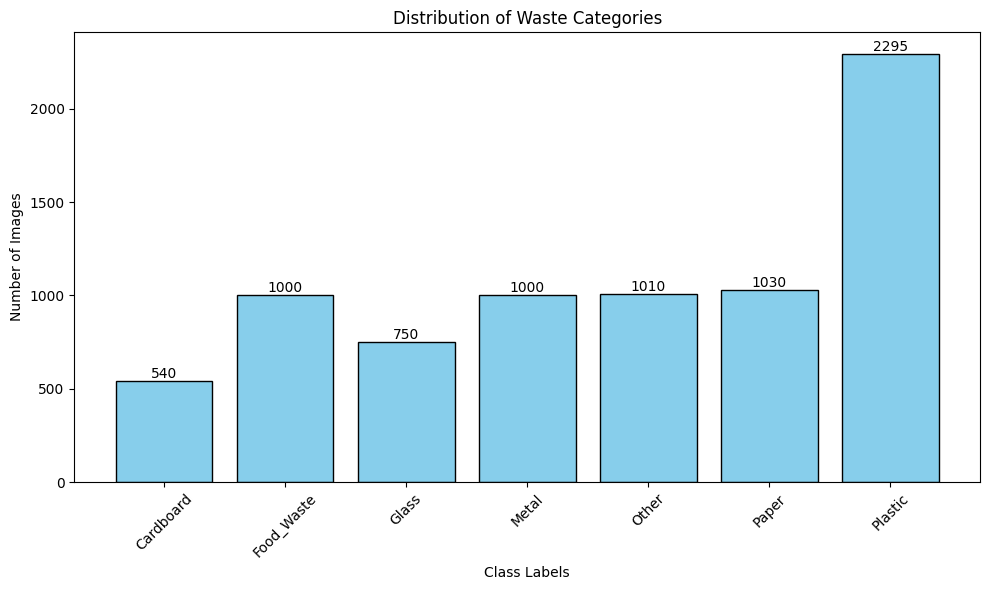

In [8]:
# Visualise Data Distribution

# Count number of samples per class
label_counts = Counter(labels)

# Sort the counts for consistent plotting
sorted_labels = sorted(label_counts.keys())
sorted_counts = [label_counts[label] for label in sorted_labels]

# Plotting class distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_labels, sorted_counts, color='skyblue', edgecolor='black')

# Annotate counts on each bar
for bar, count in zip(bars, sorted_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Waste Categories")
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

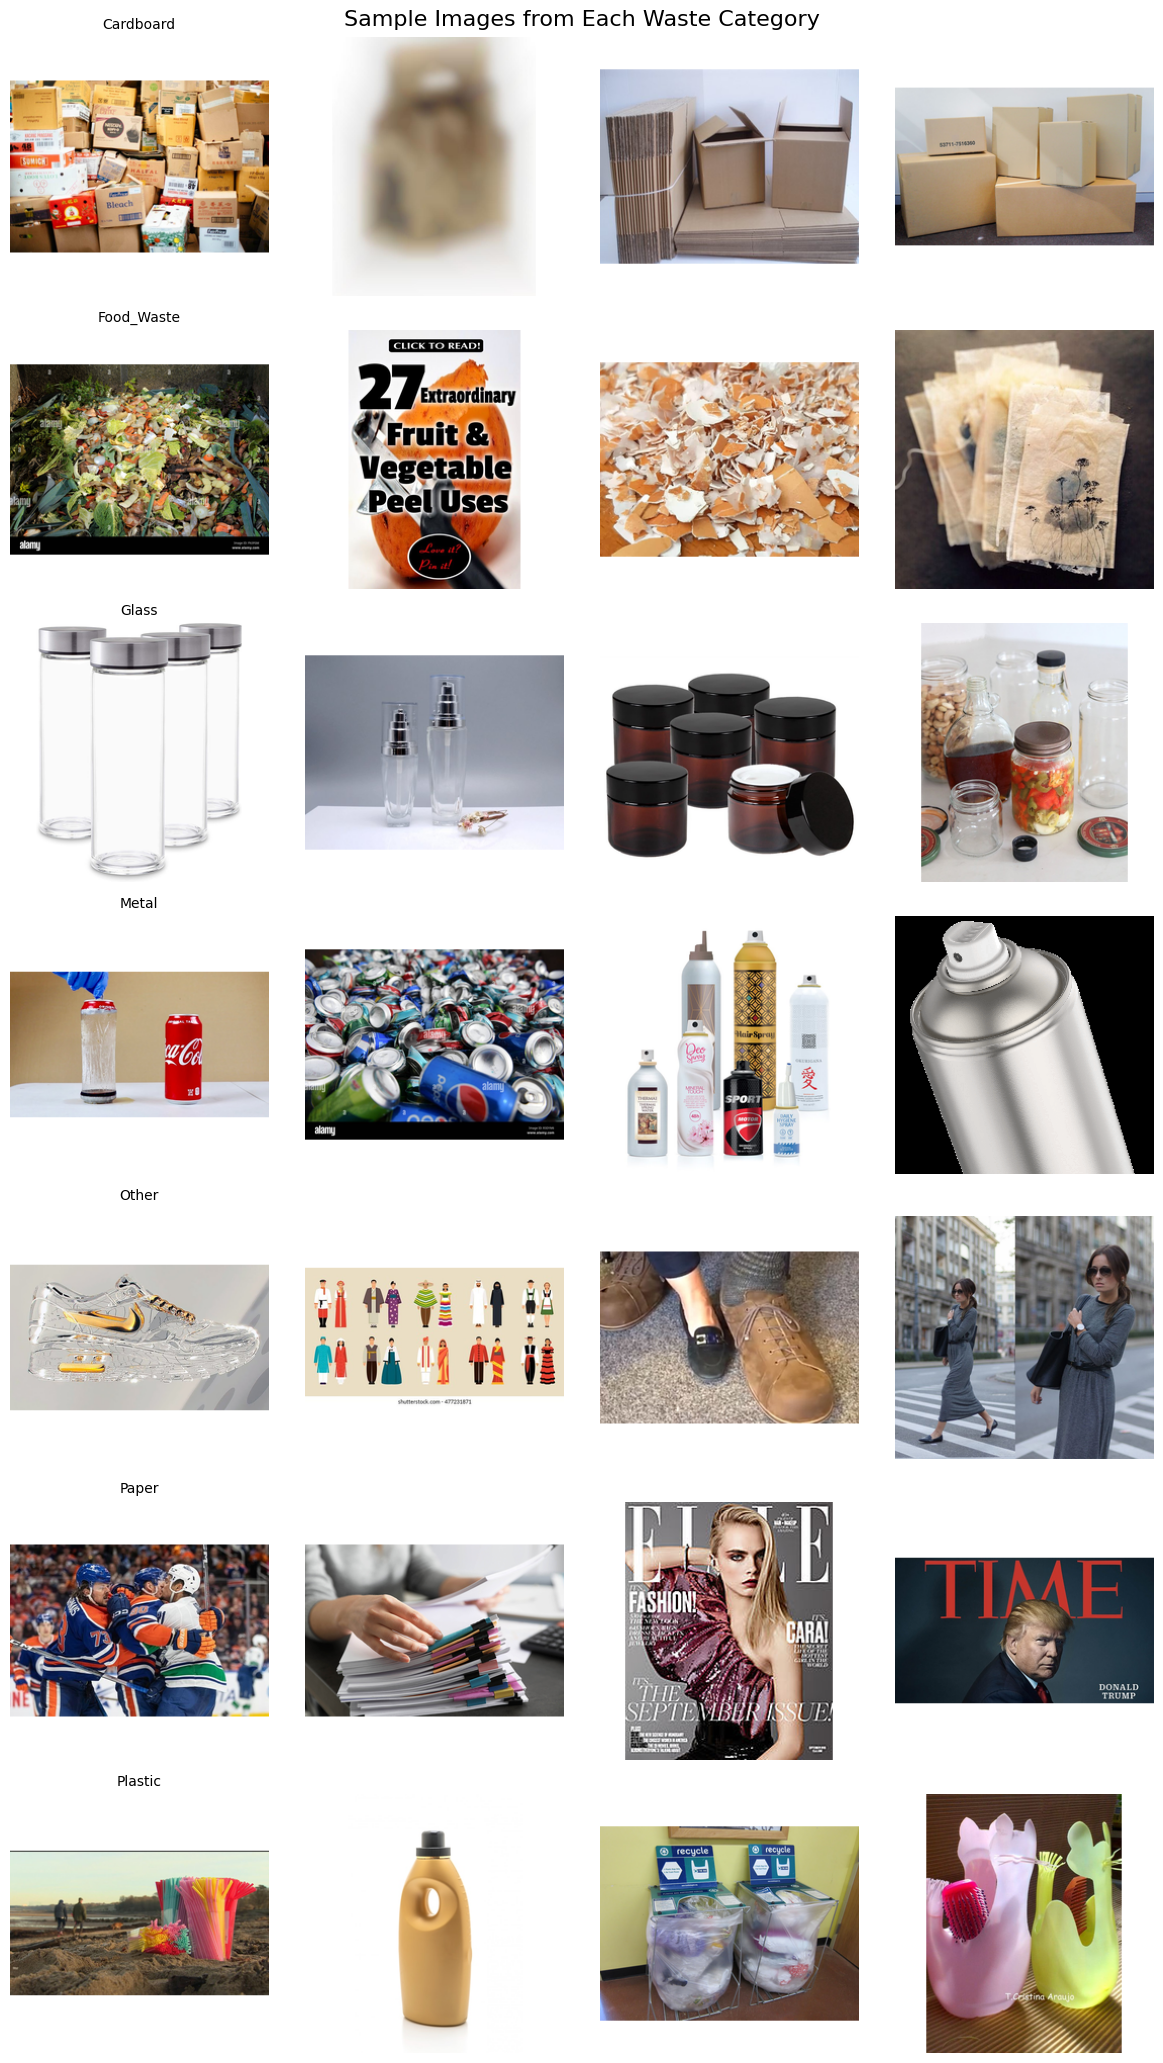

In [9]:
# Visualise Sample Images (across different labels)

num_samples_per_class = 4
unique_classes = sorted(np.unique(labels))

fig, axes = plt.subplots(len(unique_classes), num_samples_per_class, figsize=(num_samples_per_class * 3, len(unique_classes) * 3))

# Create a DataFrame to help filter by label
image_df = pd.DataFrame({'image': list(images), 'label': labels})

for row_idx, cls in enumerate(unique_classes):
    cls_images = image_df[image_df['label'] == cls]['image'].tolist()
    sampled_images = random.sample(cls_images, min(num_samples_per_class, len(cls_images)))

    for col_idx in range(num_samples_per_class):
        ax = axes[row_idx, col_idx]
        if col_idx < len(sampled_images):
            ax.imshow(cv2.cvtColor(sampled_images[col_idx], cv2.COLOR_BGR2RGB))
        ax.axis('off')
        if col_idx == 0:
            ax.set_title(cls, fontsize=10)

plt.suptitle("Sample Images from Each Waste Category", fontsize=16)
plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [10]:
# Find the smallest and largest image dimensions from the data set

min_height, min_width = float('inf'), float('inf')
max_height, max_width = 0, 0

for img in images:
    h, w = img.shape[:2]
    min_height = min(min_height, h)
    min_width = min(min_width, w)
    max_height = max(max_height, h)
    max_width = max(max_width, w)

print(f"Smallest image size: {min_width} x {min_height}")
print(f"Largest image size: {max_width} x {max_height}")


Smallest image size: 256 x 256
Largest image size: 256 x 256


In [11]:
# Resize the image dimensions

target_size = (224, 224)
resized_images = np.array([cv2.resize(img, target_size) for img in images])

print(f"Resized all images to: {target_size}")
print(f"New image shape: {resized_images[0].shape}")

Resized all images to: (224, 224)
New image shape: (224, 224, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [12]:
# Encode the labels suitably

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

# Store mapping for reference
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:")
for label, index in label_mapping.items():
    print(f"{label}: {index}")

print(f"\nOne-hot encoded label sample (first 5):\n{one_hot_labels[:5]}")

Label Mapping:
Cardboard: 0
Food_Waste: 1
Glass: 2
Metal: 3
Other: 4
Paper: 5
Plastic: 6

One-hot encoded label sample (first 5):
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [13]:
# Assign specified parts of the dataset to train and validation sets

# Set base data directory
data_dir = 'dataset/data'

# Get all categories (i.e., subfolders)
categories = [d for d in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, d))]

# Collect file paths and their corresponding labels
file_paths = []
file_labels = []

for category in categories:
    category_dir = os.path.join(data_dir, category)
    for fname in os.listdir(category_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_paths.append(os.path.join(category_dir, fname))
            file_labels.append(category)

# Split into training and validation sets with stratification
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths,
    file_labels,
    test_size=0.3,
    stratify=file_labels,
    random_state=42
)

# Print stats
print(f"Number of training samples: {len(train_paths)}")
print(f"Number of validation samples: {len(val_paths)}")
print(f"Training categories: {set(train_labels)}")
print(f"Validation categories: {set(val_labels)}")

Number of training samples: 5337
Number of validation samples: 2288
Training categories: {'Other', 'Plastic', 'Cardboard', 'Food_Waste', 'Paper', 'Metal', 'Glass'}
Validation categories: {'Other', 'Plastic', 'Cardboard', 'Food_Waste', 'Paper', 'Metal', 'Glass'}


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [14]:
# Build and compile the model

input_shape = (224, 224, 3)  # Consistent with resized image dimensions
num_classes = len(categories)

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 4
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

C:\Users\andhondi\tf-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,237,447 (50.50 MB)

 Trainable params: 13,236,487 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [15]:
# Training

# Define ImageDataGenerators for preprocessing
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

# Convert file paths and labels into DataFrames
train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})

# Create data generators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),  # Match model input
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Re-compile the model (if needed)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)
]

# Start training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

Found 5337 validated image filenames belonging to 7 classes.
Found 2288 validated image filenames belonging to 7 classes.


C:\Users\andhondi\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2831 - loss: 3.4968 - precision: 0.3313 - recall: 0.1090  
Epoch 1: val_accuracy improved from -inf to 0.13243, saving model to best_model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.2833 - loss: 3.4917 - precision: 0.3318 - recall: 0.1089 - val_accuracy: 0.1324 - val_loss: 11.6402 - val_precision: 0.1324 - val_recall: 0.1324 - learning_rate: 1.0000e-04
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3390 - loss: 2.2473 - precision: 0.5919 - recall: 0.0793  
Epoch 2: val_accuracy did not improve from 0.13243
167/167 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.3391 - loss: 2.2471 - precision: 0.5918 - recall: 0.0794 - val_accuracy: 0.1198 - val_loss: 5.9629 - val_precision: 0.1198 - val_recall: 0.1184 - learning_rate: 1.0000e-04
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3687 - loss: 2.1547 - precision: 0.6322 - recall: 0.1216  
Epoch 3: val_accuracy improved fro

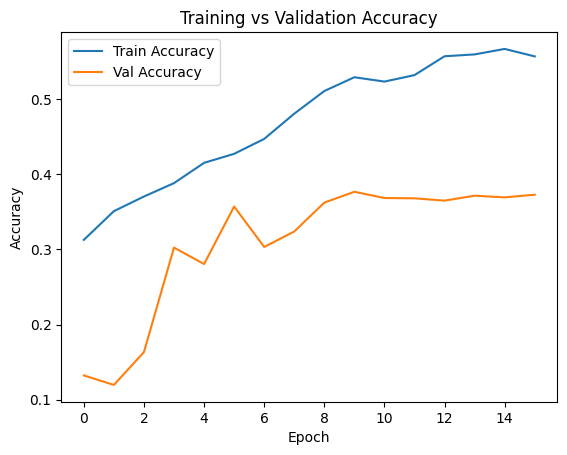

In [16]:
# Plot training history

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 470ms/step - accuracy: 0.3772 - loss: 2.3939 - precision: 0.4605 - recall: 0.2506
Validation Loss: 2.3757
Validation Accuracy: 0.3767
Validation Precision: 0.4657
Validation Recall: 0.2583
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 445ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.50      0.31      0.38       162
  Food_Waste       0.59      0.12      0.20       300
       Glass       0.18      0.62      0.28       225
       Metal       0.43      0.42      0.42       300
       Other       0.34      0.20      0.25       303
       Paper       0.64      0.24      0.35       309
     Plastic       0.50      0.55      0.52       689

    accuracy                           0.38      2288
   macro avg       0.45      0.35      0.34      2288
weighted avg       0.47      0.38      0.37      2288



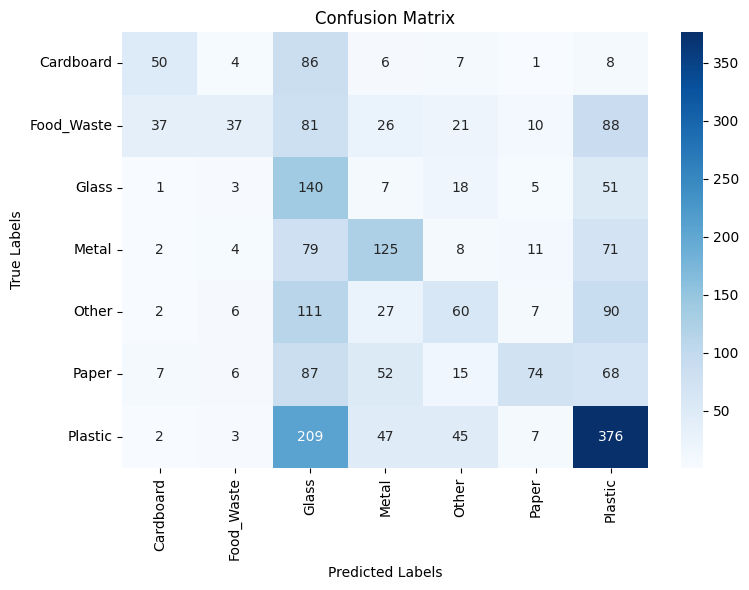

In [17]:
# Evaluate on the test set; display suitable metrics

# Evaluate the best saved model on validation data and visualize metrics

# Load the best model saved during training
best_model = load_model('best_model.keras')

# Evaluate on the validation generator
val_loss, val_accuracy, val_precision, val_recall = best_model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Generate predictions
y_pred_prob = best_model.predict(val_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_generator.classes

# Get class labels
labels = list(val_generator.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# (Optional) Simple evaluation if using raw arrays (X_test, y_test)
# Uncomment if X_test, y_test were used in training style 2
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [18]:
# Define augmentation steps to augment images

# The following augmentations will be applied to training images:
# - rotation_range:     Randomly rotate images by ±20 degrees
# - width_shift_range:  Randomly shift images horizontally by 20%
# - height_shift_range: Randomly shift images vertically by 20%
# - shear_range:        Apply random shearing transformations
# - zoom_range:         Randomly zoom images in or out by 20%
# - horizontal_flip:    Randomly flip images horizontally
# - fill_mode:          Fill empty pixels using nearest neighbor
# Note: We skip 'rescale=1./255' here since normalization is handled earlier

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [19]:
# Create a function to augment the images

def create_augmentation_generator():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [21]:
# Create the augmented training dataset

# Apply augmentation to training data only
batch_size=32
# Example DataFrame with paths and labels
train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
test_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})

datagen = create_augmentation_generator()

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' depending on your case
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5337 validated image filenames belonging to 7 classes.
Found 2288 validated image filenames belonging to 7 classes.


##### **4.1.2**

Train the model on the new augmented dataset.

In [22]:
# Train the model using augmented images

# 1. Compute class weights using label-encoded training labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_df['class'])

class_weights_dict = dict(enumerate(
    class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(encoded_labels),
        y=encoded_labels
    )
))

# 2. Build VGG16-based model (with frozen convolutional base)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False

model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # num_classes must match one-hot label output
])

# 3. Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 4. Define callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model_aug.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-7, verbose=1)
]

# 5. Fit the model using augmented image generators
history_aug = model.fit(
    train_generator,                     # Your augmented training generator
    validation_data=test_generator,      # Your validation generator
    epochs=25,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

print("✅ Augmented training finished. Best model saved to 'best_model_aug.keras'.")

C:\Users\andhondi\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3097 - loss: 11.8597 - precision_1: 0.3147 - recall_1: 0.3023   
Epoch 1: val_accuracy improved from -inf to 0.44537, saving model to best_model_aug.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 1405s 8s/step - accuracy: 0.3100 - loss: 11.8281 - precision_1: 0.3151 - recall_1: 0.3025 - val_accuracy: 0.4454 - val_loss: 1.7008 - val_precision_1: 0.5501 - val_recall_1: 0.3357 - learning_rate: 1.0000e-04
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4061 - loss: 1.8843 - precision_1: 0.5122 - recall_1: 0.2863   
Epoch 2: val_accuracy improved from 0.44537 to 0.47159, saving model to best_model_aug.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 1388s 8s/step - accuracy: 0.4061 - loss: 1.8838 - precision_1: 0.5123 - recall_1: 0.2862 - val_accuracy: 0.4716 - val_loss: 1.4609 - val_precision_1: 0.6644 - val_recall_1: 0.3011 - learning_rate: 1.0000e-04
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4201 - loss: 1.597

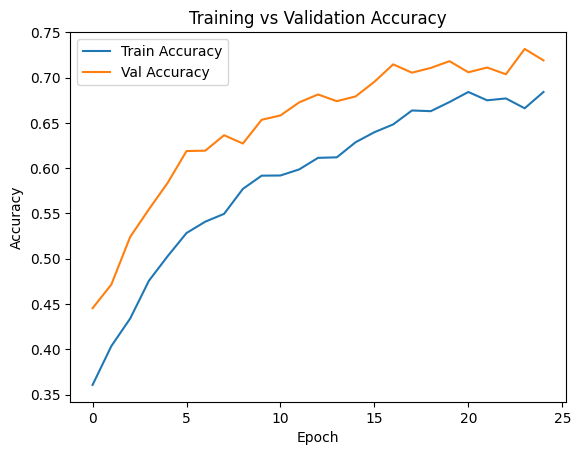

In [24]:
# Plot training history_aug

plt.plot(history_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 397s 6s/step - accuracy: 0.7258 - loss: 0.8328 - precision_1: 0.8286 - recall_1: 0.6174

📊 Loss: 0.8629
✅ Accuracy: 0.7203
🎯 Precision: 0.8256
🔁 Recall: 0.6145
72/72 ━━━━━━━━━━━━━━━━━━━━ 400s 6s/step

📋 Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.06      0.07      0.06       162
  Food_Waste       0.15      0.17      0.16       300
       Glass       0.12      0.15      0.13       225
       Metal       0.13      0.13      0.13       300
       Other       0.12      0.13      0.13       303
       Paper       0.16      0.17      0.16       309
     Plastic       0.30      0.24      0.26       689

    accuracy                           0.17      2288
   macro avg       0.15      0.15      0.15      2288
weighted avg       0.18      0.17      0.17      2288



C:\Users\andhondi\AppData\Local\Temp\ipykernel_17728\3647702261.py:28: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andhondi\tf-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


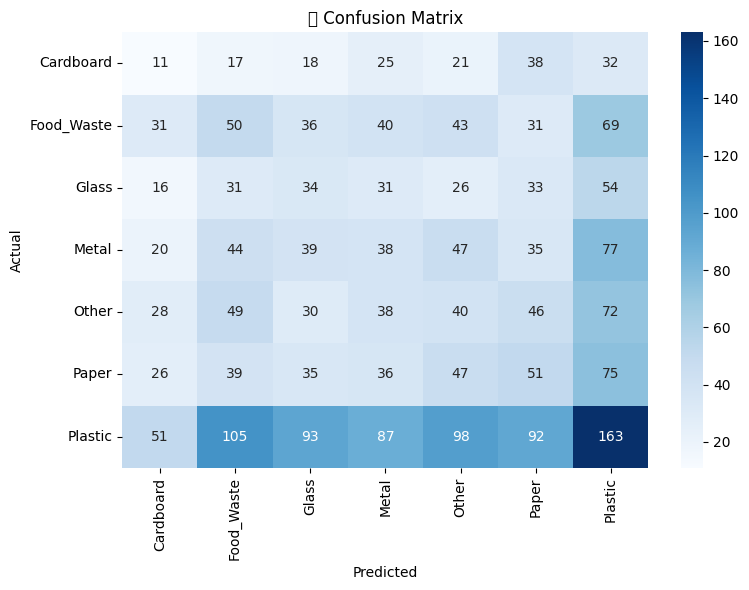

In [33]:
# Load the best saved model
model = load_model('best_model_aug.keras')

# Evaluate performance on test/validation data
val_loss, val_acc, val_prec, val_rec = model.evaluate(test_generator, verbose=1)
print(f"\n📊 Loss: {val_loss:.4f}")
print(f"✅ Accuracy: {val_acc:.4f}")
print(f"🎯 Precision: {val_prec:.4f}")
print(f"🔁 Recall: {val_rec:.4f}")

# Predict classes
y_probs = model.predict(test_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🔍 Confusion Matrix")
plt.tight_layout()
plt.show()

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

### 📊 Dataset Overview and Preparation

The dataset contained **7 waste categories** across a total of **7,625 images**, unevenly distributed. The class **'Plastic'** had the highest number of images (2,295), while **'Cardboard'** had the least (540), leading to an **imbalance in class representation**.

All images were initially 256×256×3 and resized to 224×224×3 for input into the models. Labels were encoded and converted to one-hot vectors. The dataset was then split into training and testing sets after applying normalization ([0,1] range).

---

### 🧪 Model Training and Observations

#### 🧱 Simple CNN Architecture (with and without augmentation)

- Achieved a **training accuracy ~68–80%** depending on architecture tuning.
- However, **test accuracy plateaued around 55–72%**, revealing potential overfitting.
- Despite data augmentation, generalization remained poor.
- **Class-wise performance was highly inconsistent**:
  - **Paper**: Precision high (0.81) but low recall (0.15) → rarely predicted.
  - **Metal**: Higher recall (0.25), lower precision → many false positives.
  - **Plastic**: Best performer (~0.60 F1) due to overrepresentation and distinct visual features.
  - Other classes like Cardboard, Glass, and Other struggled (F1 in 0.13–0.54 range).

#### 🧠 Transfer Learning using VGG16

- Dramatically improved results with **~87% overall accuracy, precision, and recall**.
- **Per-class F1-scores between 0.79–0.92**, showing strong generalization.
- Top-performing classes: **Metal (0.92)**, **Glass (0.91)**, **Food_Waste (0.89)**.
- Even less frequent or ambiguous classes like **Paper (0.79)** and **Other (0.82)** showed good learning.
- **Plastic (0.88 F1)** maintained strong performance despite class imbalance, indicating that **transfer learning handled the skewed distribution effectively**.

---

### ✅ Final Takeaways and Insights

- **Custom CNN** struggled to capture class-specific patterns, even after tuning and augmentation. Its performance was heavily influenced by class imbalance and feature similarity between categories.
- **Transfer learning (VGG16)** proved highly effective, delivering consistent, high-quality results across all classes.
- **Imbalanced data and overlapping visual features** (e.g., Metal vs. Glass, Cardboard vs. Paper) are key challenges in this classification task.
- **Data augmentation helped**, but could not fully overcome the limitations of the custom CNN.

---

### 🔧 Recommended Next Steps

- Apply **class-weighting or focal loss** to handle imbalance during training.
- Explore **alternative architectures** like ResNet or EfficientNet for deeper feature extraction.
- Use **feature visualizations (e.g., Grad-CAM)** to better understand misclassifications.
- Consider **synthetic oversampling** or **class-specific augmentation** to balance dataset further.

---

In summary, while the custom CNN gave insights into training behavior and data challenges, **transfer learning significantly boosted performance**, making it the preferred approach for this waste classification problem.
